In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import utilities.graphing_utils as utl

In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
df['bmi'].fillna(df['bmi'].median(), inplace = True) #fill na with median

In [4]:
#dropping 'other' gender instance due to one-off outlier
df.drop(df.index[df['gender'] == 'Other'], inplace = True)


In [5]:
#processing smoking as an ordinal categorical variable
df["smoking_status"]=df["smoking_status"].map({"Unknown": 0,"never smoked" : 1,"formerly smoked" : 2,"smokes" : 3})

In [6]:
#get dummies for rest of categorical features
df = pd.get_dummies(df, drop_first=True)

## Modeling

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [8]:
#declaring features and target variable. Using features with highest and lowest correlation to target variable Attrition
X = df.drop(columns=['stroke', 'id'])
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size= 0.4)

In [9]:
ss = StandardScaler()

Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [10]:
rfc = RandomForestClassifier(max_depth=6)
rfc.fit(Xs_train, y_train)
rfc.score(Xs_train, y_train), rfc.score(Xs_test, y_test)

(0.9520391517128874, 0.9510763209393346)

In [11]:
d = {'Column Name':X_train.columns,'Feature Importance':rfc.feature_importances_}
fi = pd.DataFrame(d)

#top 10 features of importance
fi.sort_values(by=['Feature Importance'], ascending = False).head(10)

,Column Name,Feature Importance
0,age,0.324862
3,avg_glucose_level,0.237215
4,bmi,0.152151
5,smoking_status,0.061954
2,heart_disease,0.052691
1,hypertension,0.047999
7,ever_married_Yes,0.034112
12,Residence_type_Urban,0.022582
10,work_type_Self-employed,0.020853
9,work_type_Private,0.020497


In [12]:
def get_metrics(test_model):
    y_pred = test_model.predict(Xs_test)
    recall = round(recall_score(y_test, y_pred),2)
    accuracy = round(accuracy_score(y_test, y_pred),2)
    print(f'Recall score for this data {recall},\nAccuracy score for this data is {accuracy}')
    
    return plot_confusion_matrix(test_model, Xs_test, y_test, cmap='inferno')


Recall score for this data 0.0,
Accuracy score for this data is 0.95


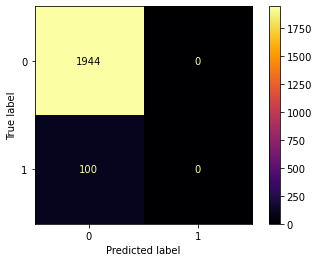

In [13]:
get_metrics(rfc);

### Modeling with Smote due to imbalanced classes

In [14]:
#reference: https://git.generalassemb.ly/plarkin13/8.07-imbalanced-data/blob/master/H_imbalanced_classes_solutions.ipynb
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter
from imblearn.pipeline import Pipeline

smo = SMOTE()

Xs_train_smote, y_train_smote = smo.fit_resample(Xs_train, y_train)

#print_sampling_stats(Xs_train, X_train_smote, y_train, y_train_smote,y_test)

In [15]:
Xs_test.shape

(2044, 13)

In [16]:
y_test.shape

(2044,)

In [17]:
y_train_smote.shape

(5832,)

In [18]:
Xs_train_smote.shape

(5832, 13)

In [19]:
rfc_smote = RandomForestClassifier(max_depth=6)
rfc_smote.fit(Xs_train_smote, y_train_smote)
rfc_smote.score(Xs_train_smote, y_train_smote), rfc_smote.score(Xs_test, y_test)

(0.8705418381344308, 0.7397260273972602)

In [20]:
d = {'Column Name': X_train.columns,'Feature Importance':rfc_smote.feature_importances_}
fi = pd.DataFrame(d)

#top 10 features of importance
fi.sort_values(by=['Feature Importance'], ascending = False).head(10)

,Column Name,Feature Importance
0,age,0.455333
5,smoking_status,0.148709
7,ever_married_Yes,0.125195
4,bmi,0.068294
3,avg_glucose_level,0.053009
11,work_type_children,0.034970
1,hypertension,0.031459
2,heart_disease,0.024937
12,Residence_type_Urban,0.017500
9,work_type_Private,0.015073


In [21]:
print(classification_report(y_test, rfc_smote.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.98      0.74      0.84      1944
           1       0.12      0.69      0.21       100

    accuracy                           0.74      2044
   macro avg       0.55      0.72      0.53      2044
weighted avg       0.94      0.74      0.81      2044



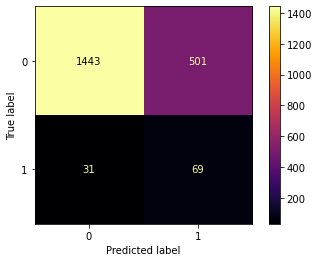

In [22]:
plot_confusion_matrix(rfc_smote, Xs_test, y_test, cmap='inferno');

### Modeling with RandomOversampler due to imbalanced classes

In [23]:
ros = RandomOverSampler()
Xs_train_over, y_train_over = ros.fit_resample(Xs_train, y_train)

"""print_sampling_stats(Xs_train, X_train_over,
                     y_train, y_train_over,
                     y_test)"""

rfc_ros = RandomForestClassifier(max_depth=6)
rfc_ros.fit(Xs_train_over, y_train_over)
rfc_ros.score(Xs_train_over, y_train_over), rfc_ros.score(Xs_test, y_test)

(0.8539094650205762, 0.7040117416829745)

In [24]:
d = {'Column Name': X_train.columns,'Feature Importance':rfc_ros.feature_importances_}
fi = pd.DataFrame(d)

#top 10 features of importance
fi.sort_values(by=['Feature Importance'], ascending = False).head(10)

,Column Name,Feature Importance
0,age,0.574535
4,bmi,0.105962
3,avg_glucose_level,0.100550
7,ever_married_Yes,0.052140
11,work_type_children,0.046130
1,hypertension,0.043784
2,heart_disease,0.025881
5,smoking_status,0.020440
10,work_type_Self-employed,0.012102
12,Residence_type_Urban,0.008158


In [25]:
print(classification_report(y_test, rfc_ros.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.98      0.70      0.82      1944
           1       0.12      0.77      0.20       100

    accuracy                           0.70      2044
   macro avg       0.55      0.74      0.51      2044
weighted avg       0.94      0.70      0.79      2044



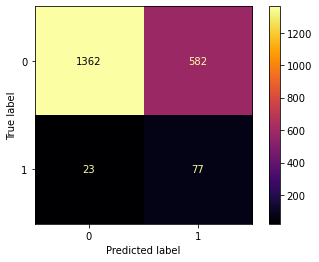

In [26]:
plot_confusion_matrix(rfc_ros, Xs_test, y_test, cmap='inferno');

### Random UnderSampler:

In [27]:
rus = RandomUnderSampler()

Xs_train_under, y_train_under = rus.fit_resample(Xs_train, y_train)

'''print_sampling_stats(Xs_train, X_train_under,
                    y_train, y_train_under,
                    y_test)'''

rfc_rus = RandomForestClassifier(max_depth=10)
rfc_rus.fit(Xs_train_under, y_train_under)
rfc_rus.score(Xs_train_under, y_train_under), rfc_rus.score(Xs_test, y_test)

(0.9966442953020134, 0.6805283757338552)

In [28]:
print(classification_report(y_test, rfc_rus.predict(Xs_test)))

              precision    recall  f1-score   support

           0       0.99      0.67      0.80      1944
           1       0.11      0.81      0.20       100

    accuracy                           0.68      2044
   macro avg       0.55      0.74      0.50      2044
weighted avg       0.94      0.68      0.77      2044



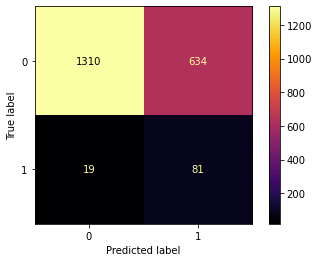

In [29]:
plot_confusion_matrix(rfc_rus, Xs_test, y_test, cmap='inferno');

# Trying Different Models

- Random Forest Classifier
- Logistic Regression
- Support Vector Machine (SVM)
- K Nearest Neighbor
- Decision Tree
- Extremely Randomized Trees (ExtraTrees)
- Naive Bayes
- XGBoost
- Possible neural network for tinkering purposes

#### Logistic regression

In [74]:
from sklearn.linear_model import LogisticRegression
lr_pipe = Pipeline([
        ('scale', StandardScaler()),
        ('sampling', RandomOverSampler(random_state=42)),
        ('lr', LogisticRegression(max_iter = 5000, class_weight='balanced'))
    ])

lr_pipe_params = {
    'sampling__sampling_strategy': ['auto', 0.75],
    'lr__C': [0.001, 0.01],
    'lr__class_weight': ['balanced']
    
}
lr_gs = RandomizedSearchCV(lr_pipe, lr_pipe_params, scoring = 'recall', cv = 3, return_train_score= True)
lr_gs.fit(X_train, y_train)
lr_preds_gs = lr_gs.predict(X_test)
print("Best Training Score", round(lr_gs.cv_results_['mean_train_score'].max(),3))
print("Best Test Score: ", lr_gs.best_score_)
print("Best Params: ", lr_gs.best_params_)

/Users/plarkin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Training Score 0.842
Best Test Score:  0.8190476190476191
Best Params:  {'sampling__sampling_strategy': 'auto', 'lr__class_weight': 'balanced', 'lr__C': 0.01}


Recall score for this data 0.0,
Accuracy score for this data is 0.95


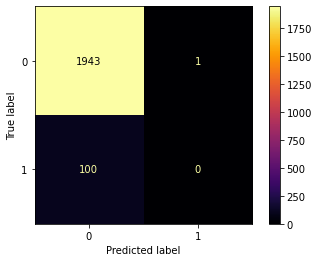

In [71]:
get_metrics(lr_gs);

In [94]:
y_train.value_counts()

0    2916
1     149
Name: stroke, dtype: int64

In [93]:
y_train_over.value_counts()

0    2916
1    2916
Name: stroke, dtype: int64

0.7746913580246914, 0.7328767123287672
Recall score for this data 0.78,
Accuracy score for this data is 0.73


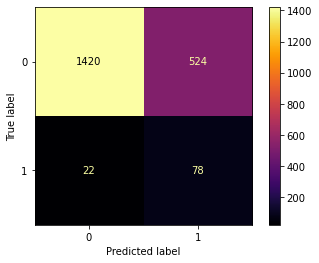

In [79]:
#trying out best params with locallized oversampling

lr_ros = LogisticRegression(class_weight='balanced',C=0.01)
lr_ros.fit(Xs_train_over, y_train_over)
print(f'{lr_ros.score(Xs_train_over, y_train_over)}, {lr_ros.score(Xs_test, y_test)}')
get_metrics(lr_ros);

#### Decision Tree
https://git.generalassemb.ly/DSI-R-628/6.02-bootstrapping-bagging/blob/master/sols.ipynb

In [61]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
dt_pipe = Pipeline([
        ('scale', StandardScaler()),
        ('sampling', RandomOverSampler(random_state=42)),
        ('dt', DecisionTreeClassifier(random_state = 42, class_weight= 'balanced')) #adding class weight due to imbalanced target data
    ])

dt_pipe_params = {
    'sampling__sampling_strategy': ['auto', 0.75],
    'dt__max_depth': [None, 3, 5],
    'dt__min_samples_split': [3,4,5],
    'dt__min_samples_leaf' : [1,2],
    
}
dt_gs = RandomizedSearchCV(dt_pipe, dt_pipe_params, scoring = 'recall', cv = 3, return_train_score= True)
dt_gs.fit(X_train, y_train)
dt_preds_gs = dt_gs.predict(X_test)
print("Best Training Score", round(dt_gs.cv_results_['mean_train_score'].max(),3))
print("Best Test Score: ", round(dt_gs.best_score_,3))
print("Best Params: ", dt_gs.best_params_)


Best Training Score 1.0
Best Test Score:  0.852
Best Params:  {'sampling__sampling_strategy': 0.75, 'dt__min_samples_split': 4, 'dt__min_samples_leaf': 1, 'dt__max_depth': 3}


Recall score for this data 0.0,
Accuracy score for this data is 0.95


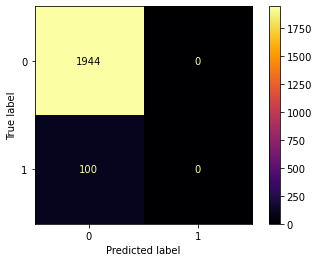

In [62]:
get_metrics(dt_gs);

0.8040123456790124, 0.6506849315068494
Recall score for this data 0.85,
Accuracy score for this data is 0.65


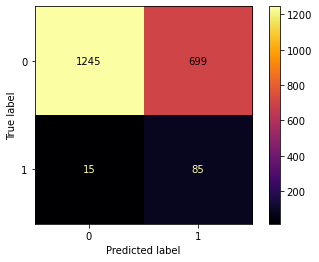

In [83]:
#trying out best params with locallized oversampling

dt_ros = DecisionTreeClassifier(random_state = 42, class_weight= 'balanced',min_samples_split =4, min_samples_leaf =1, max_depth= 3)
dt_ros.fit(Xs_train_over, y_train_over)
print(f'{dt_ros.score(Xs_train_over, y_train_over)}, {dt_ros.score(Xs_test, y_test)}')
get_metrics(dt_ros);

In [88]:
d = {'Column Name': X_train.columns,'Feature Importance':dt_ros.feature_importances_}
fi = pd.DataFrame(d)

#top 10 features of importance
fi.sort_values(by=['Feature Importance'], ascending = False).head(10)

,Column Name,Feature Importance
0,age,0.925002
4,bmi,0.068163
1,hypertension,0.006835
2,heart_disease,0.000000
3,avg_glucose_level,0.000000
5,smoking_status,0.000000
6,gender_Male,0.000000
7,ever_married_Yes,0.000000
8,work_type_Never_worked,0.000000
9,work_type_Private,0.000000


#### Extremely Randomized Trees (ExtraTrees)
https://git.generalassemb.ly/DSI-R-628/6.03-random-forest-extra-trees/blob/master/Random_Forest_Extra_Trees_sols.ipynb

In [57]:
from sklearn.ensemble  import ExtraTreesClassifier

extt_pipe = Pipeline([
        ('scale', StandardScaler()),
        ('sampling', RandomOverSampler(random_state=42)),
        ('dt', DecisionTreeClassifier(random_state = 42, class_weight= 'balanced')) #adding class weight due to imbalanced target data
    ])

extt_pipe_params = {
    'sampling__sampling_strategy': ['auto', 0.75],
    'dt__max_depth': [None, 3, 5],
    'dt__min_samples_split': [3,4,5],
    'dt__min_samples_leaf' : [1,2],
    
}
extt_gs = RandomizedSearchCV(extt_pipe, extt_pipe_params, scoring = 'recall', cv = 3, return_train_score=True)
extt_gs.fit(X_train, y_train)
extt_preds_gs = extt_gs.predict(X_test)
print("Best Training Score", round(extt_gs.cv_results_['mean_train_score'].max(),3))
print("Best Test Score: ", round(extt_gs.best_score_,3))
print("Best Params: ", extt_gs.best_params_)



Best Training Score 1.0
Best Test Score:  0.852
Best Params:  {'sampling__sampling_strategy': 0.75, 'dt__min_samples_split': 3, 'dt__min_samples_leaf': 1, 'dt__max_depth': 3}


Recall score for this data 0.0,
Accuracy score for this data is 0.95


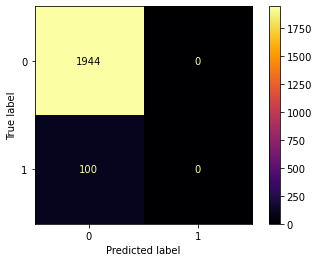

In [35]:
get_metrics(extt_gs);

0.7731481481481481, 0.6340508806262231
Recall score for this data 0.84,
Accuracy score for this data is 0.63


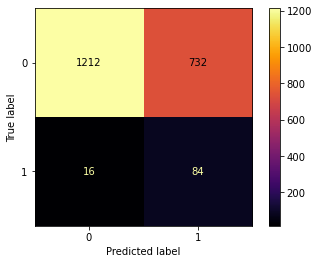

In [84]:
#trying out best params with locallized oversampling

extt_ros = ExtraTreesClassifier(random_state = 42, class_weight= 'balanced',min_samples_split =3, min_samples_leaf =1, max_depth= 3)
extt_ros.fit(Xs_train_over, y_train_over)
print(f'{extt_ros.score(Xs_train_over, y_train_over)}, {extt_ros.score(Xs_test, y_test)}')
get_metrics(extt_ros);


#### Support Vector Machine (SVM)
https://git.generalassemb.ly/DSI-R-628/6.06-lesson-svms/blob/master/solution-code/solution-code.ipynb

In [64]:
from sklearn.svm import SVC
svc_pipe = Pipeline([
        ('scale', StandardScaler()),
        ('sampling', RandomOverSampler(random_state=42)),
        ('svc', SVC(gamma="scale"))
    ])

svc_pipe_params = {
    'sampling__sampling_strategy': ['auto', 0.75],
    'svc__C': [0.001, 0.01],
    'svc__kernel': ['rbf', 'sigmoid']
    
}
svc_gs = RandomizedSearchCV(svc_pipe, svc_pipe_params, scoring = 'recall', cv = 3, return_train_score=True)
svc_gs.fit(X_train, y_train)
svc_preds_gs = svc_gs.predict(X_test)

print("Best Training Score", round(svc_gs.cv_results_['mean_train_score'].max(),3))
print("Best Test Score: ", round(svc_gs.best_score_,3))
print("Best Params: ", svc_gs.best_params_)


/Users/plarkin/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Training Score 0.909
Best Test Score:  0.919
Best Params:  {'svc__kernel': 'sigmoid', 'svc__C': 0.01, 'sampling__sampling_strategy': 'auto'}


Recall score for this data 0.05,
Accuracy score for this data is 0.93


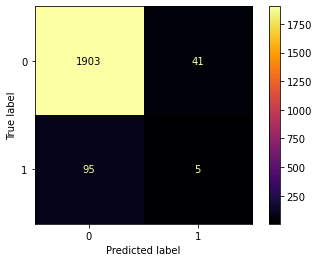

In [65]:
get_metrics(svc_gs);

0.7760631001371742, 0.6501956947162426
Recall score for this data 0.83,
Accuracy score for this data is 0.65


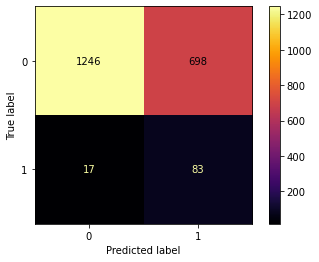

In [85]:
#trying out best params with locallized oversampling

svc_ros = SVC(gamma="scale", C=0.01,kernel='sigmoid')
svc_ros.fit(Xs_train_over, y_train_over)
print(f'{svc_ros.score(Xs_train_over, y_train_over)}, {svc_ros.score(Xs_test, y_test)}')
get_metrics(svc_ros);


#### K Nearest Neighbor (KNN)
https://git.generalassemb.ly/DSI-R-628/4.03-knn/blob/master/KNN-sols.ipynb

In [67]:
from sklearn.neighbors import KNeighborsClassifier
knn_pipe = Pipeline([
        ('scale', StandardScaler()),
        ('sampling', RandomOverSampler(random_state=42)),
        ('knn', KNeighborsClassifier())
    ])

knn_pipe_params = {
    'sampling__sampling_strategy': ['auto', 0.75],
    'knn__weights': ['uniform', 'distance'],
    'knn__n_neighbors': [3,5,7],
    'knn__p' : [1,2]
    
}
knn_gs = RandomizedSearchCV(knn_pipe, knn_pipe_params, scoring = 'recall', cv = 3, return_train_score=True)
knn_gs.fit(X_train, y_train)
knn_preds_gs = knn_gs.predict(X_test)

print("Best Training Score", round(knn_gs.cv_results_['mean_train_score'].max(),3))
print("Best Test Score: ", round(knn_gs.best_score_,3))
print("Best Params: ", knn_gs.best_params_)



Best Training Score 1.0
Best Test Score:  0.348
Best Params:  {'sampling__sampling_strategy': 0.75, 'knn__weights': 'uniform', 'knn__p': 1, 'knn__n_neighbors': 7}


Recall score for this data 0.08,
Accuracy score for this data is 0.92


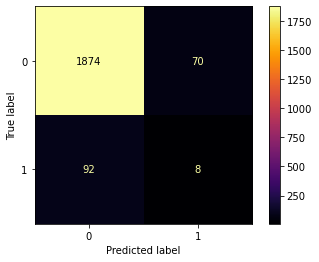

In [39]:
get_metrics(knn_gs);

0.9391289437585734, 0.8233855185909981
Recall score for this data 0.32,
Accuracy score for this data is 0.82


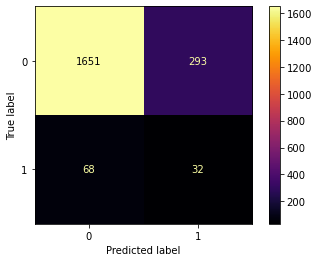

In [86]:
#trying out best params with locallized oversampling

knn_ros = KNeighborsClassifier(weights= 'uniform',  p=1, n_neighbors=7)
knn_ros.fit(Xs_train_over, y_train_over)
print(f'{knn_ros.score(Xs_train_over, y_train_over)}, {knn_ros.score(Xs_test, y_test)}')
get_metrics(knn_ros);


#### Naive Bayes (not used since it is unable to handle negative numbers within features)


#### XGBoost
- intro-to-boosting-solution.ipynb https://git.generalassemb.ly/DSI-R-628/6.05-lesson-boosting

- params for xgboost https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [40]:
#from xgboost import XGBClassifier
xgb_pipe = Pipeline([
        ('scale', StandardScaler()),
        ('sampling', RandomOverSampler(random_state=42)),
        ('xgb', XGBClassifier(use_label_encoder=False))
    ])

xgb_pipe_params = {
    'sampling__sampling_strategy': ['auto', 0.75],
    
}
xgb_gs = RandomizedSearchCV(xgb_pipe, xgb_pipe_params, scoring = 'recall', cv = 3, return_train_score=True)
xgb_gs.fit(X_train, y_train)
xgb_gs = xgb_gs.predict(X_test)
print("Best Score: ", xgb_gs.best_score_)
print("Best Params: ", xgb_gs.best_params_)
get_metrics(xgb_gs);

NameError: name 'XGBClassifier' is not defined

#### Possible neural network

In [41]:
print(Xs_train.shape, y_train.shape)
input_shape=Xs_train.shape
# may need to reshape or do numpy array of X variable

(3065, 13) (3065,)


In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU #GRU = Gated Recurring Units
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

model = Sequential()
model.add(GRU(8, input_shape=input_shape, return_sequences=True)) # True if next layer is RNN
model.add(GRU(8, return_sequences=False)) # False if next layer is Dense

model.add(Dense(4, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='bce', metrics=['recall'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

history = model.fit(Xs_train, y_train, validation_data = (Xs_test, y_test),
                 batch_size = 20, epochs = 200, verbose =1, callbacks=[early_stop])


2021-09-20 19:38:11.309101: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


NotImplementedError: Cannot convert a symbolic Tensor (gru/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)

plt.legend(fontsize = 18);

In [ ]:
max(history.history['val_accuracy'])

#### Ensemble model of all models?
https://machinelearningmastery.com/ensemble-machine-learning-algorithms-python-scikit-learn/

### Pickle model for streamlit

In [ ]:
import pickle

In [ ]:
with open('models/draft1.pkl', 'wb') as pickle_out:
    pickle.dump(rfc_smote, pickle_out)

In [ ]:
 with nopen('./models/draft1.pkl', 'rb') as pickle_in:
        model = pickle.load(pickle_in)

Now open with VScode
https://www.youtube.com/watch?v=Klqn--Mu2pE